In [ ]:
#This example code assumes you have already constructed
#your full database of covariates, including anything (i.e., Clinics) you have
#downloaded from google maps.
#Further, it relies on conflict events in Liberia (as opposed to your assignment)
#which asks for Syria.

#The purpose of this assignment is to use simulation to establish what model
#best estimates conflict under conditions of uncertainty, in both
#your ancillary data (the data you use to predict) as well as
#your conflict outcome varaible (the variable you are predicting).

#Library imports:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
import numpy as np


In [ ]:
#First, I am loading my completed CSV in.
full_dta = pd.read_csv("/sciclone/home2/geogdan/Project_3/model_dta.csv", delimiter=",")
print(len(full_dta))

In [ ]:
#I have many columns of data I want to keep this time, but there are a few not relevant for this analysis.
#Columns before we drop:
print(full_dta.columns.values )

remove_columns_dta = full_dta.drop('NL_NAME_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('ID_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('ID_0', axis=1)
remove_columns_dta = remove_columns_dta.drop('ID_1', axis=1)
remove_columns_dta = remove_columns_dta.drop('ISO', axis=1)
remove_columns_dta = remove_columns_dta.drop('ID_2', axis=1)
remove_columns_dta = remove_columns_dta.drop('CCA_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('CCN_3', axis=1)

#I accidently requested v4composites_calibrated two times, so received duplicate data
#in my CSV file.  Here, I'm removing columns based on a text
#match (all duplicates end in ".1")
remove_columns_dta = remove_columns_dta[remove_columns_dta.columns.drop(list(remove_columns_dta.filter(regex='\.1')))]

remove_columns_dta = remove_columns_dta.drop('asdf_id', axis=1)
remove_columns_dta = remove_columns_dta.drop('NAME_2', axis=1)
remove_columns_dta = remove_columns_dta.drop('NAME_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('NAME_0', axis=1)
remove_columns_dta = remove_columns_dta.drop('NAME_1', axis=1)
remove_columns_dta = remove_columns_dta.drop('VARNAME_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('TYPE_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('ENGTYPE_3', axis=1)

#Save this as a shorter name for convenience
fin_dta = remove_columns_dta

#Columns after we drop:
print("=========================== AFTER DROPPING ==========================")
print(remove_columns_dta.columns.values )

In [ ]:
#Do a description of my data.
#Make sure the variable you're trying to predict
#has meaningful information!
pd.set_option('display.max_columns',500)
remove_columns_dta.describe()

In [ ]:
#Ultimately, I seek to predict 'acled_v3_count.none.sum'.
#By reading the metadata provided with this variable, I know this
#value is a sum of conflict events, where larger values.
#indicate more conflict.

#First, we're going to calculate a (very simple) linear model,
#and assess how good it's fit is.  We're going to use
#SciKit Learn for this, as all of the models we will test
#are within that module for most of the rest of this course.

from sklearn.cross_validation import train_test_split

#We have to manipulate our Pandas dataframe in a few ways to
#ensure it's compatible with SciKit
columns = fin_dta.columns.tolist()

#Establish the variable we will be predicting
prediction_var = "acled_v3_count.none.sum"
print("Predicting the variable: " + prediction_var)

#Make a list of all the datasets we're predicitng with
#We need to remove the dataset we're predicting.
data_to_predict_with = fin_dta.drop(prediction_var,1).columns.tolist()
print("Predicting with the data:")
print(data_to_predict_with)

# Generate a dataset to calibrate our model with
# We will test our model against the remaining data.

calibrate_data = fin_dta.sample(frac=0.8)
testing_data = fin_dta.loc[~fin_dta.index.isin(calibrate_data.index)]



In [ ]:
#Sanity check - how big is our training and test data?
from sklearn import linear_model
print(len(calibrate_data))
print(len(testing_data))

#Convert our pandas dataframe over to Numpy, 
#which is required for SciKit (the tool we're using for models)
data_to_predict_with_np = calibrate_data[data_to_predict_with].values
prediction_var_np = calibrate_data[prediction_var].values

#Same for our test data:
data_to_predict_tests = testing_data[data_to_predict_with].values
prediction_var_test_np = testing_data[prediction_var].values

In [ ]:
#Let's fit a linear model as in project 2
#but this time, using SciKit Learn
from sklearn import linear_model

#Fit the model with our *calibration* dataset:
regression_model = linear_model.LinearRegression()
regression_model.fit(X=data_to_predict_with_np,y=prediction_var_np)

#Predict the results for our *test* dataset:
prediction_reg = regression_model.predict(data_to_predict_tests)

#This calculates a linear weighted combination estimate of conflict based on our
#model coefficients.
#These coefficients are listed in the same order as
#print(data_to_predict_with)
print(regression_model.coef_)

print("=====Predicted Mean Conflict Events for Test Dataset=======")
print(prediction_reg)


In [ ]:
#Lets look at how well our linear model did
#Note this can be different dependign on your cross-validation dataset
#When we only do it once.
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

print(mean_absolute_error(y_true=prediction_var_test_np, y_pred=prediction_reg))
print(median_absolute_error(y_true=prediction_var_test_np, y_pred=prediction_reg))

In [ ]:
#Let's fit a Bayes model as our second
#model to compare.
#You can learn more about Bayes Ridge Regression - and many more SciKit models -
# at http://scikit-learn.org/stable/supervised_learning.html

#Here we need to define prior
#assumptions.  In this case, we are defining the shape of a gamma distribution
#through the terms alpha 1 and lambda 1.
#This is used as the "prior assumption" for bayes (i.e.,
#in the coin flip example, we assume a 50/50 split.  This gaussian distribution
#describes our prior belief as to the likely values of our parameters).

from sklearn import linear_model

BRR_model = linear_model.BayesianRidge(alpha_1 = 10, lambda_1=5)
BRR_model.fit(X=data_to_predict_with_np,y=prediction_var_np)
prediction_BRR = BRR_model.predict(data_to_predict_tests)

#How did it do?
print(mean_absolute_error(y_true=prediction_var_test_np, y_pred=prediction_BRR))
print(median_absolute_error(y_true=prediction_var_test_np, y_pred=prediction_BRR))


In [ ]:
#Now, we want to setup a loop that looks across all of our models to see which one performs best.
#We'll start simple, just doing a linear model.
#Because we're iterating, we'll be changing our cross-validation subset each time.

from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
import timeit

#We'll time the runs for later steps...
start_time = timeit.default_timer()

iterations = 1000
count = 0
linear_reg_MAE = []
linear_reg_model = []
linear_reg_r2 = []

while count < iterations:
    
    #Build four datasets each iteration - 
    #(D-1) A calibration dataset of covariates
    #(D-2) A calibration dataset of outcomes
    #(D-3) A validation dataset of covariates
    #(D-4) A validation dataset of outcomes
    #We'll also go ahead and convert everything over to numpy.
    
    #Building D1 and D2:
    #Take 60% of our data and put it into calibration.
    calibrate_data = fin_dta.sample(frac=0.60)
    #D-1
    calibrate_covariates = calibrate_data[data_to_predict_with].values
    #D-2
    calibrate_outcomes = calibrate_data[prediction_var].values
    
    
    #Building D3 and D4:
    #Take the other 40% of our data and use it for testing.
    test_data = fin_dta.loc[~fin_dta.index.isin(calibrate_data.index)]

    #D-3
    test_covariates = test_data[data_to_predict_with].values
    #D-4
    test_outcomes = test_data[prediction_var].values
    
    #==================================================
    #Build linear models with this calibration and test data
    regression_model = linear_model.LinearRegression()
    regression_model.fit(X=calibrate_covariates,y=calibrate_outcomes)
    prediction_reg = regression_model.predict(test_covariates)
    
    linear_reg_MAE.append(mean_absolute_error(y_true=test_outcomes, y_pred=prediction_reg))
    linear_reg_model.append(regression_model)
    linear_reg_r2.append(r2_score(y_true=test_outcomes, y_pred=prediction_reg))
    
    count = count + 1


#Iteration ID of best model:
best_id = linear_reg_MAE.index(min(linear_reg_MAE))
best_MAE = linear_reg_MAE[best_id]
best_r2 = linear_reg_r2[best_id]

#Best overall model based on MAE
print("Best Model ID and MAE:")
print(best_id)
print(best_MAE)

#Distribution of all R2 from all models (this is analgolous to what you did in project 2)
#Note: R2 can go below -1 in this case, as we're validating against
#a dataset other than that which we used to fit our data.
#This can happen when your model is *even worse* than simply assuming
#the mean value ine very case.
#sns.distplot(linear_reg_r2)

#Let's look at the distribution of MAE
sns.distplot(linear_reg_MAE, norm_hist=False, kde=False)

stop_time = timeit.default_timer()
print("Runtime in seconds:")
print(stop_time - start_time)

#Question to think about:
#Based on the results from this section, what is the best and worst accuracy achieved by this model?
#In terms of the observed data, is that accuracy acceptable?
#Would you advocate for the use of this model in a real-world scenario?  Why or why not?


In [ ]:
#Let's complicate our above code by adding the Bayes approach in:
from random import *
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
import timeit

#We'll time the runs for later steps...
start_time = timeit.default_timer()

iterations = 100
count = 0
linear_reg_MAE = []
linear_reg_model = []

bayes_reg_MAE = []
bayes_reg_model = []

while count < iterations:
    
    #Build four datasets each iteration - 
    #(D-1) A calibration dataset of covariates
    #(D-2) A calibration dataset of outcomes
    #(D-3) A validation dataset of covariates
    #(D-4) A validation dataset of outcomes
    #We'll also go ahead and convert everything over to numpy.
    
    #Building D1 and D2:
    #Take 60% of our data and put it into calibration.
    calibrate_data = fin_dta.sample(frac=0.60)
    #D-1
    calibrate_covariates = calibrate_data[data_to_predict_with].values
    #D-2
    calibrate_outcomes = calibrate_data[prediction_var].values
    
    
    #Building D3 and D4:
    #Take the other 40% of our data and use it for testing.
    test_data = fin_dta.loc[~fin_dta.index.isin(calibrate_data.index)]

    #D-3
    test_covariates = test_data[data_to_predict_with].values
    #D-4
    test_outcomes = test_data[prediction_var].values
    
    #==================================================
    #Build linear models with this calibration and test data
    regression_model = linear_model.LinearRegression()
    regression_model.fit(X=calibrate_covariates,y=calibrate_outcomes)
    prediction_reg = regression_model.predict(test_covariates)
    
    linear_reg_MAE.append(mean_absolute_error(y_true=test_outcomes, y_pred=prediction_reg))
    linear_reg_model.append(regression_model)

    
    
      
    #==================================================
    #Bayes Modeling
    #Here, we're going to loop again, because we want to test across
    #a number of different alpha_1 and lambda_1 values.
    bayes_iterations = iterations
    bayes_counter = 0
    while bayes_counter < bayes_iterations:
        a = random()
        l = random()
        BRR_model = linear_model.BayesianRidge(alpha_1 = a, lambda_1=l)
        BRR_model.fit(X=calibrate_covariates,y=calibrate_outcomes)
        prediction_BRR = BRR_model.predict(test_covariates)

        #Save the results.  We'll have more Bayes models due to the alpha and lambda search.
        bayes_reg_MAE.append(mean_absolute_error(y_true=test_outcomes, y_pred=prediction_BRR))
        bayes_reg_model.append(BRR_model)
        bayes_counter = bayes_counter + 1
        


    count = count + 1

#Iteration ID of best model for regression:
best_id_lr = linear_reg_MAE.index(min(linear_reg_MAE))
best_MAE_lr = linear_reg_MAE[best_id_lr]


#Best overall model based on MAE
print("Best Model ID and MAE for Linear Regression:")
print(best_id_lr)
print(best_MAE_lr)


#Iteration ID of best model for Bayes Ridge Regression:
best_id_bayes = bayes_reg_MAE.index(min(bayes_reg_MAE))
best_MAE_bayes = bayes_reg_MAE[best_id_bayes]

print("Best Model ID and MAE for Bayes:")
print(best_id_bayes)
print(best_MAE_bayes)

#Distributions:
sns.distplot(linear_reg_MAE, norm_hist=False, kde=False, label="Linear Regression")
sns.distplot(bayes_reg_MAE, norm_hist=False, kde=False, label="Bayes Ridge Reg")
plt.legend()

stop_time = timeit.default_timer()
print("Runtime in seconds:")
print(stop_time - start_time)

#Questions to consider:
#Which of these two models would you use so far?
#How much error could you expect if you used them?
#How might you improve the estimation of the models?

In [ ]:
#Finally, we need to add uncertainty in.
#This follows the same approach as project 2,
#except we will automatically assign uncertainty 
#to all of our variables according to a generalized assumption
#of gaussian uncertainty and a level of confidence
#we want to achieve.

from random import *
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
import timeit

#We'll time the runs for later steps...
start_time = timeit.default_timer()

iterations = 10
count = 0

#Level of potential error in our data, following a
#normal distribution for every variable.
uncertainty_range = .10

linear_reg_MAE = []
linear_reg_model = []

bayes_reg_MAE = []
bayes_reg_model = []

while count < iterations:

    #Generate our new dataset that we will introduce uncertainty into.
    sim_dta = fin_dta.applymap(lambda x: x +(np.random.normal(0, uncertainty_range/1.645, 1) * x))

    calibrate_data = sim_dta.sample(frac=0.60)
    calibrate_covariates = calibrate_data[data_to_predict_with].values
    calibrate_outcomes = calibrate_data[prediction_var].values
    
    #Building D3 and D4:
    #Take the other 40% of our data and use it for testing.
    test_data = sim_dta.loc[~sim_dta.index.isin(calibrate_data.index)]

    #D-3
    test_covariates = test_data[data_to_predict_with].values
    #D-4
    test_outcomes = test_data[prediction_var].values
    
    #==================================================
    #Build linear models with this calibration and test data
    regression_model = linear_model.LinearRegression()
    regression_model.fit(X=calibrate_covariates,y=calibrate_outcomes)
    prediction_reg = regression_model.predict(test_covariates)
    
    linear_reg_MAE.append(mean_absolute_error(y_true=test_outcomes, y_pred=prediction_reg))
    linear_reg_model.append(regression_model)

    
    
      
    #==================================================
    #Bayes Modeling
    #Here, we're going to loop again, because we want to test across
    #a number of different alpha_1 and lambda_1 values.
    bayes_iterations = iterations
    bayes_counter = 0
    while bayes_counter < bayes_iterations:
        a = random()
        l = random()
        BRR_model = linear_model.BayesianRidge(alpha_1 = a, lambda_1=l)
        BRR_model.fit(X=calibrate_covariates,y=calibrate_outcomes)
        prediction_BRR = BRR_model.predict(test_covariates)

        #Save the results.  We'll have more Bayes models due to the alpha and lambda search.
        bayes_reg_MAE.append(mean_absolute_error(y_true=test_outcomes, y_pred=prediction_BRR))
        bayes_reg_model.append(BRR_model)
        bayes_counter = bayes_counter + 1
        


    count = count + 1

#Iteration ID of best model for regression:
best_id_lr = linear_reg_MAE.index(min(linear_reg_MAE))
best_MAE_lr = linear_reg_MAE[best_id_lr]


#Best overall model based on MAE
print("Best Model ID and MAE for Linear Regression:")
print(best_id_lr)
print(best_MAE_lr)


#Iteration ID of best model for Bayes Ridge Regression:
best_id_bayes = bayes_reg_MAE.index(min(bayes_reg_MAE))
best_MAE_bayes = bayes_reg_MAE[best_id_bayes]
print("==========================")
print("Best Model ID and MAE for Bayes:")
print(best_id_bayes)
print(best_MAE_bayes)

#Distributions:
sns.distplot(linear_reg_MAE, norm_hist=False, kde=False, label="Linear Regression")
sns.distplot(bayes_reg_MAE, norm_hist=False, kde=False, label="Bayes Ridge Reg")
plt.legend()

stop_time = timeit.default_timer()
print("==========================")
print("Runtime in seconds:")
print(stop_time - start_time)

#Consider two questions:
#(1) How can I add more (or less) uncertainty into certain variables?
#(2) How has the distribution generated with uncertainty changed as contrasted
#to the distribution generated without uncertainty?

#Stats:
#10 Models - 1.28 seconds
#100 Models - 36.52 seconds
#1000 Models - 520.23 seconds (~9 minutes)

Loading Modules


/usr/local/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Launching Cluster
<Client: scheduler='tcp://127.0.0.1:44556' processes=64 cores=64>
Job submission initialized.  Cluster tasks being generated.
[<Future: status: pending, key: scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-0>, <Future: status: pending, key: scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-1>, <Future: status: pending, key: scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-2>, <Future: status: pending, key: scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-3>, <Future: status: pending, key: scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-4>, <Future: status: pending, key: scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-5>, <Future: status: pending, key: scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-6>, <Future: status: pending, key: scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-7>, <Future: status: pending, key: scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-8>, <Future: status: pending, key: scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-9>, <Future: status

{'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-36': [], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-52': ['tcp://127.0.0.1:36290'], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-17': ['tcp://127.0.0.1:33443'], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-37': [], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-24': ['tcp://127.0.0.1:40689'], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-12': [], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-50': ['tcp://127.0.0.1:37675'], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-16': [], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-27': ['tcp://127.0.0.1:36207'], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-22': ['tcp://127.0.0.1:42900'], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-32': [], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-43': [], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-3': [], 'scikit_rand-1c4b3ddc-1d78-4881-a9eb-60afffde6dd4-21': ['tcp://127.0.0.1:44467'], 'scikit_rand-

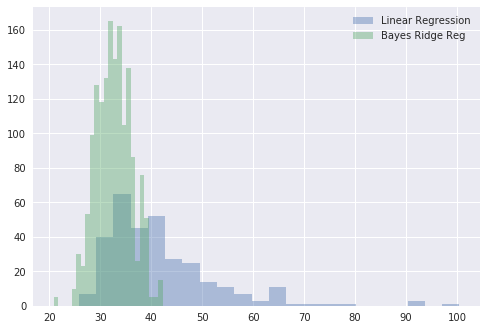

In [1]:
print("Loading Modules")
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
import numpy as np
from random import *
from sklearn import linear_model
import seaborn as sns
import timeit
from time import sleep
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error
from operator import add
from itertools import chain

full_dta = pd.read_csv("/sciclone/home2/geogdan/Project_3/model_dta.csv", delimiter=",")
remove_columns_dta = full_dta.drop('NL_NAME_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('ID_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('ID_0', axis=1)
remove_columns_dta = remove_columns_dta.drop('ID_1', axis=1)
remove_columns_dta = remove_columns_dta.drop('ISO', axis=1)
remove_columns_dta = remove_columns_dta.drop('ID_2', axis=1)
remove_columns_dta = remove_columns_dta.drop('CCA_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('CCN_3', axis=1)

#I accidently requested v4composites_calibrated two times, so received duplicate data
#in my CSV file.  Here, I'm removing columns based on a text
#match (all duplicates end in ".1")
remove_columns_dta = remove_columns_dta[remove_columns_dta.columns.drop(list(remove_columns_dta.filter(regex='\.1')))]

remove_columns_dta = remove_columns_dta.drop('asdf_id', axis=1)
remove_columns_dta = remove_columns_dta.drop('NAME_2', axis=1)
remove_columns_dta = remove_columns_dta.drop('NAME_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('NAME_0', axis=1)
remove_columns_dta = remove_columns_dta.drop('NAME_1', axis=1)
remove_columns_dta = remove_columns_dta.drop('VARNAME_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('TYPE_3', axis=1)
remove_columns_dta = remove_columns_dta.drop('ENGTYPE_3', axis=1)

#Save this as a shorter name for convenience
fin_dta = remove_columns_dta

#We have to manipulate our Pandas dataframe in a few ways to
#ensure it's compatible with SciKit
columns = fin_dta.columns.tolist()

#Establish the variable names
prediction_var = "acled_v3_count.none.sum"
data_to_predict_with = fin_dta.drop(prediction_var,1).columns.tolist()

#We'll time the runs for later steps...
#As the above illustrates, adding uncertainty into these simulations
#can add quite a lot of time to the calculations.
#Every iteration is currently taking around 0.15 seconds (check this on your own! Your data may take longer).
#In this example, we are permuting (a) 30 variables by adding uncertainty and (b) two parameters (alpha and lambda for bayes)
#If we want at least 100 samples to describe any single distribution, to capture all of these interacting parameters we 
#want 100 ^ 32 or 1e^64 simulations.  This would take approximately the time a newborn sun takes to burn out.
#Recognizing we can't possibly capture *every* possibility, instead we will randomly sample as many as we can reasonably do with
#Sciclone and the resources allocated to you on Jupyter.
#We are limited to 64 processes on 32 cores for 6 hours.

#First, we initalize our distributed cores - note this will take a few minutes each time:
from dask.distributed import Client

print("Launching Cluster")
client = Client()  # set up local cluster on your laptop
print(client)

#Start a timer for comparison
start_time = timeit.default_timer()

#Second, we need to take the code we wrote in the previous snippet and 
#turn it into a function we can send off to each client to
#work on:

def scikit_rand(iterations = 5):
    count = 0

    #Level of potential error in our data, following a
    #normal distribution for every variable.
    uncertainty_range = .10

    linear_reg_MAE = []
    linear_reg_model = []

    bayes_reg_MAE = []
    bayes_reg_model = []

    while count < iterations:

        sim_dta = fin_dta.applymap(lambda x: x +(np.random.normal(0, uncertainty_range/1.645, 1) * x))
        calibrate_data = sim_dta.sample(frac=0.60)
        calibrate_covariates = calibrate_data[data_to_predict_with].values
        calibrate_outcomes = calibrate_data[prediction_var].values

        test_data = sim_dta.loc[~sim_dta.index.isin(calibrate_data.index)]
        test_covariates = test_data[data_to_predict_with].values
        test_outcomes = test_data[prediction_var].values

        #==================================================
        #Build linear models with this calibration and test data
        regression_model = linear_model.LinearRegression()
        regression_model.fit(X=calibrate_covariates,y=calibrate_outcomes)
        prediction_reg = regression_model.predict(test_covariates)

        linear_reg_MAE.append(mean_absolute_error(y_true=test_outcomes, y_pred=prediction_reg))
        linear_reg_model.append(regression_model)

        #==================================================
        #Bayes Modeling
        bayes_iterations = iterations
        bayes_counter = 0
        while bayes_counter < bayes_iterations:
            a = random()
            l = random()
            BRR_model = linear_model.BayesianRidge(alpha_1 = a, lambda_1=l)
            BRR_model.fit(X=calibrate_covariates,y=calibrate_outcomes)
            prediction_BRR = BRR_model.predict(test_covariates)

            #Save the results.  We'll have more Bayes models due to the alpha and lambda search.
            bayes_reg_MAE.append(mean_absolute_error(y_true=test_outcomes, y_pred=prediction_BRR))
            bayes_reg_model.append(BRR_model)
            bayes_counter = bayes_counter + 1

        count = count + 1
    return(linear_reg_MAE,linear_reg_model,bayes_reg_MAE,bayes_reg_model)

#Now, we can call clients and distribute the functions as we want:
core_iterations = [None] * 63 # 63 cores (2 threads / core) (we save one for Jupyter just in case)
for i in range(63):
    core_iterations[i] = 5 #Every node will do 5 iterations.

job_submission = client.map(scikit_rand,core_iterations, pure=False)
print("Job submission initialized.  Cluster tasks being generated.")
print(job_submission)

#A small while loop so we can keep track of what's going on:
while(any(word in str(job_submission[0:62]) for word in ['pending'])):
    sleep(10)
    print(client.who_has(job_submission))
      
if(any(word in str(job_submission[0:62]) for word in ['error'])):
    print("There was an error!")
else:
    stop_time = timeit.default_timer()
    print("Runtime in seconds:")
    print(stop_time - start_time)

    lr_results = []
    for i in range(63):
        lr_results.append(client.gather(job_submission)[i][0])
    lr_results =list(chain(*lr_results))
    
    
        
    brr_results = []
    for i in range(63):
        brr_results.append(client.gather(job_submission)[i][2])
    brr_results =list(chain(*brr_results))
    
    sns.distplot(client.gather(lr_results), norm_hist=False, kde=False, label="Linear Regression")
    sns.distplot(client.gather(brr_results), norm_hist=False, kde=False, label="Bayes Ridge Reg")
    plt.legend()


In [ ]:
#Questions:
#Which model performs best?
#What is the minimum number of iterations you need to capture the true relationship?  How can you justify?
#What's the absolute best you could do in terms of % error?